# Hyperparameter optimization for machine learning

Many machine learning models have hyperparamters -- parameters that control some aspect of the model. The exact setting of these hyperparameters can dramatically impact the performance of your underlying model. Fortunately, most hyperparameters can be tried in parallel, making the task of *hyperparemter optimization* a great fit for PyWren. 

Here we use a simple dataset included in scikit-learn to show how to do hyperparameter optimization across a number of different datasets, and a number of different cross-validations 

In [5]:
%pylab inline
import pywren
import sklearn
import seaborn as sns
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn.svm

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


# get the data

First we load in the data from scikit learn and examine it. Here we will be using an existing dataset of breast cancer tumor properties that's shipped with scikit-learn. This is a small binary classification problem, and the hyperparameter optimization we are doing here is reletively trivial. Hopefully this will inspire good ideas. 

In [3]:
# load the dataset from scikit learn
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()

Let's explore properties of the dataset. 

In [16]:
print(bc['DESCR'])

Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        

The data is in the `data` key and the classification label is in the `target` key. Load those:

In [17]:
# load the data as X and y
X = bc['data']
y = bc['target']

First we explore generic prediction on the dataset with an off-the-shelf classifier. We use a scikit-learn pipeline which does the following:

1. standardize each input feature to zero-mean unit variance 
2. Apply a SVM with a given set of hyperparameters

In [6]:

# create a train/test split for cross-validation
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.2, random_state=0)

# construct a scikit learn pipeline which normalizes
# the data and then runs a SVM 

p = Pipeline(steps=[('standardize', StandardScaler()), 
                    ('learn', sklearn.svm.SVC(C=0.1, kernel='poly', degree=3))])


# fit the data
p.fit(X_train, y_train)


0.81578947368421051

Then we can evaluate the behavior of the classifier on the held-out set

In [18]:

# predict the held-out data
pred = p.predict(X_test)

# measure the accuracy
sklearn.metrics.accuracy_score(y_test, pred)

0.85964912280701755

# use PyWren to try many HP values

Now we try for many folds and many hyperparameters with pywren. We can also try many different folds to get confidence intervals on the sensitivyt of our new estimator. 


In [19]:
# now we can train lots of models! and get error bars! 

def train_model(args):
    """
    
    """
    # extract the args
    (X_train, X_test, y_train, y_test), hps = args
    
    import sklearn.svm 
    
    # create the pipeline
    p = Pipeline(steps=[('standardize', StandardScaler()), 
                        ('learn', sklearn.svm.SVC(**hps))])
    
    # fit
    p.fit(X_train, y_train)
    return p


wrenexec = pywren.default_executor()


FOLD_N = 10 # number of cross-validation sets

cv_sets = []
for i in range(FOLD_N):
    cv_sets.append(train_test_split(
                     X, y, test_size=0.4, random_state=i))

# set of SVM hyperparameters we want to try
hps =  [dict(C=10.0, kernel='rbf', degree=3), 
        dict(C=1.0, kernel='rbf', degree=3),
        dict(C=0.1, kernel='rbf', degree=3)]


# combine them all using itertools
args = list(itertools.product(cv_sets, hps) )


In [20]:
# perform the map
import sklearn.ensemble.forest
futures = wrenexec.map(train_model, args)
results = pywren.get_all_results(futures)

# Analyzing the results

We construct a dataframe of the results to facilitate subsequent analysis

In [21]:
# construct a dataframe using the resulting models to predict accuracy on their held-out dataset
res = []
for m, ((X_train, X_test, y_train, y_test), hps) in zip(results, args):
    pred = m.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, pred)
    hp_row = hps.copy()
    hp_row['accuracy'] = acc
    res.append(hp_row)
df = pd.DataFrame(res)

### we use seaborn to plot the results

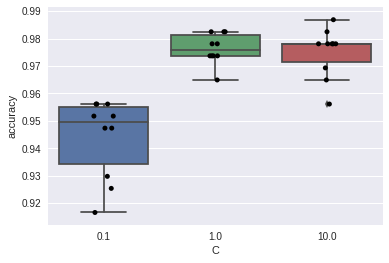

In [22]:
sns.boxplot(x='C', y='accuracy', data=df)
sns.stripplot(x='C', y='accuracy', data=df, color='k', jitter=True)


# Exercise: Try different classifiers

Many different classifiers can work for the simple binary classification problem. We encourage you to try several from scikit learn below

In [33]:
# now we can train lots of models! and get error bars! 

def train_model(args):
    """
    
    """
    # extract the args
    (X_train, X_test, y_train, y_test), (classifier_name, hps) = args
    
    import sklearn.svm 
    import sklearn.ensemble
    
    # create the pipeline
    if classifier_name == "svm":
        p = Pipeline(steps=[('standardize', StandardScaler()), 
                            ('learn', sklearn.svm.SVC(**hps))])
    elif classifier_name == "randomforest":
        # TODO CREATE YOUR PIPELINE HERE
        p = Pipeline(steps=[('learn', 
                            sklearn.ensemble.RandomForestClassifier(**hps))])
        
    ## TODO ADD MORE 
    
    # fit
    p.fit(X_train, y_train)
    return p


wrenexec = pywren.default_executor()


FOLD_N = 4 # number of cross-validation sets

cv_sets = []
for i in range(FOLD_N):
    cv_sets.append(train_test_split(
                     X, y, test_size=0.4, random_state=i))

# set of SVM hyperparameters we want to try
models_and_hps =  [('svm', dict(C=10.0, kernel='rbf', degree=3)), 
                   ('svm', dict(C=1.0, kernel='rbf', degree=3)),
                   ('svm', dict(C=0.1, kernel='rbf', degree=3)), 
                   ('randomforest', {'n_estimators' : 5}), 
                   ('randomforest', {'n_estimators' : 20}),
                   ('randomforest', {'n_estimators' : 100}),
                  ]


# combine them all using itertools
args = list(itertools.product(cv_sets, models_and_hps) )


In [34]:
# perform the map  
## TODO call pywren and get the results
futures = wrenexec.map(train_model, args)
results = pywren.get_all_results(futures)

In [35]:
# construct a dataframe using the resulting models to predict accuracy on their held-out dataset
res = []
for m, ((X_train, X_test, y_train, y_test), (model_name, hps)) in zip(results, args):
    pred = m.predict(X_test)
    acc = sklearn.metrics.accuracy_score(y_test, pred)
    hp_row = hps.copy()
    hp_row['accuracy'] = acc
    hp_row['hp_str'] = str(hps)
    hp_row['model_name'] = model_name
    res.append(hp_row)
df = pd.DataFrame(res)

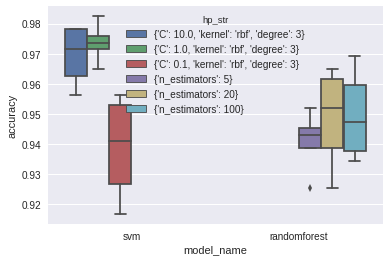

In [36]:
sns.boxplot(x='model_name', y='accuracy', data=df, hue="hp_str")
#sns.stripplot(x='C', y='accuracy', data=df, color='k', jitter=True)
